# Create synthetic import/export costs based on EPEX prices
The general structure for formulating prices was taken from https://www.guylipman.com/octopus/formulas.html

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys, pkgutil
print(sys.executable)
print('nbformat found? ', pkgutil.find_loader('nbformat') is not None)
%pip install -U nbformat plotly ipykernel

import plotly.io as pio
pio.renderers.default = "vscode"  # or "notebook_connected"
import plotly.graph_objects as go


/srv/fh6281/GermanBuildingDate/venv/bin/python
nbformat found?  True
Note: you may need to restart the kernel to use updated packages.


In [2]:
start_time = pd.Timestamp('2020-01-01 00:00:00+00:00')
end_time = pd.Timestamp('2020-12-31 23:00:00+00:00')

In [3]:
df = pd.read_csv('temp_data/cleaned_energy_prices.csv' , parse_dates=['timestamp'])

# rename column Day-ahead Price (EUR/MWh)_hourly to price
df.rename(columns={'Day-ahead Price (EUR/MWh)_hourly': 'price'}, inplace=True)

df['price'] = df['price'] / 1000 # Convert price from EUR/MWh to EUR/kWh
df = df[(df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)].copy()

<Axes: title={'center': 'Filtered EPEX Prices'}, xlabel='Timestamp', ylabel='Price (EUR/kWh)'>

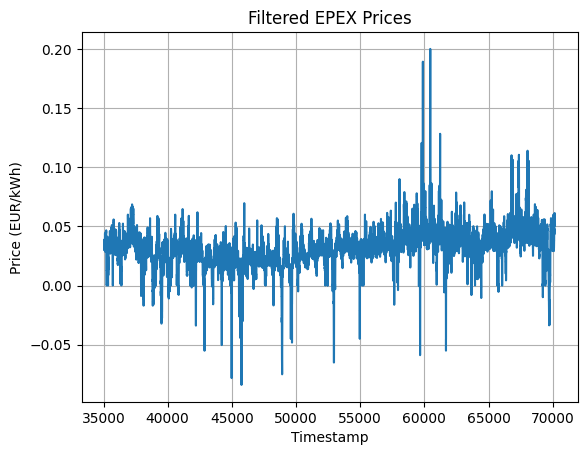

In [4]:
df['price'].plot(grid=True, title='Filtered EPEX Prices', ylabel='Price (EUR/kWh)', xlabel='Timestamp')

In [5]:
def get_import_prices(row, hour_p_start=16, hour_p_end=18, P_pence=13.0, D=2.1, VAT=1.19, tz='Europe/Berlin'):
    # P is in pence/kWh => Tranform it to €/kWh
    # For year 2020, 1 pence circa equals 0.0115 EUR
    P_euro = P_pence * 0.0115 # €/kWh

    # transform the row to the local time zone
    row['timestamp'] = row['timestamp'].tz_convert(tz)
    # get the hour in the local time zone
    h = row['timestamp'].hour
    # retransform the row to utc
    row['timestamp'] = row['timestamp'].tz_convert('UTC')


    if hour_p_start <= h <= hour_p_end:
        P_now = P_euro
    else:
        P_now = 0

    # German Stromsteuer?
    P_now += 0.0205 # €/kWh

    return (D * row['price'] + P_now) * VAT


def get_export_prices(row, hour_p_start=16, hour_p_end=18, D=0.95, P_pence1=1.09, P_pence2=7.04, tz='Europe/Berlin'):

    # transform the row to the local time zone
    row['timestamp'] = row['timestamp'].tz_convert(tz)
    # get the hour in the local time zone
    h = row['timestamp'].hour
    # retransform the row to utc
    row['timestamp'] = row['timestamp'].tz_convert('UTC')

    # P is in pence/kWh => Tranform it to €/kWh
    # For year 2020, 1 pence circa equals 0.0115 EUR
    P_euro1 = P_pence1 * 0.0115  # €/kWh
    P_euro2 = P_pence2 * 0.0115  # €/kWh

    if hour_p_start <= h <= hour_p_end:
        P_now = P_euro1 + P_euro2
    else:
        P_now = P_euro1

    return max(D * row['price'] + P_now, 0)  # Ensure that export prices are not negative

In [63]:
# default values from octopus
# df_estimation = df.copy()
# df_estimation['import_price'] = df_estimation.apply(
#     lambda row: get_import_prices(
#         row,
#     ),
#     axis=1
# )
# df_estimation['export_price'] = df_estimation.apply(
#     lambda row: get_export_prices(
#         row,
#     ),
#     axis=1
# )

# CHECK WHAT THIS IS
# df_estimation = df.copy()
# df_estimation['import_price'] = df_estimation.apply(
#     lambda row: get_import_prices(
#         row,
#         P_pence=5.0,
#         D=2.5
#     ),
#     axis=1
# )
# df_estimation['export_price'] = df_estimation.apply(
#     lambda row: get_export_prices(
#         row,
#         P_pence2=2.0,
#         D=0.95
#     ),
#     axis=1
# )


# rule-based dominates here => called electricity_price_estimation3.csv
# df_estimation = df.copy()
# df_estimation['import_price'] = df_estimation.apply(
#     lambda row: get_import_prices(
#         row,
#         hour_p_start=16,
#         hour_p_end=18,
#         P_pence=0.0,
#         D=8.0,
#         VAT=1.19,
#         tz='Europe/Berlin'
#     ),
#     axis=1
# )
# df_estimation['export_price'] = df_estimation.apply(
#     lambda row: get_export_prices(
#         row,
#         hour_p_start=16,
#         hour_p_end=18,
#         P_pence1=1.09,
#         P_pence2=0.0,
#         D=2.4,
#         tz='Europe/Berlin'
#     ),
#     axis=1
# )

# electricity_price_estimationDImp5.csv But without TOU Character
df_estimation = df.copy()
df_estimation['import_price'] = df_estimation.apply(
    lambda row: get_import_prices(
        row,
        hour_p_start=16,
        hour_p_end=18,
        P_pence=0.0,
        D=8.0,
        VAT=1.19,
        tz='Europe/Berlin'
    ),
    axis=1
)
df_estimation['export_price'] = df_estimation.apply(
    lambda row: get_export_prices(
        row,
        hour_p_start=16,
        hour_p_end=18,
        P_pence1=1.09,
        P_pence2=0.0,
        D=5.0,
        tz='Europe/Berlin'
    ),
    axis=1
)


# electricity_price_estimation4.csv => Decrease gap between import/export prices based on electricity_price_estimation3.csv
# df_estimation = df.copy()
# df_estimation['import_price'] = df_estimation.apply(
#     lambda row: get_import_prices(
#         row,
#         hour_p_start=16,
#         hour_p_end=18,
#         P_pence=0.0,
#         D=8.0,
#         VAT=1.19,
#         tz='Europe/Berlin'
#     ),
#     axis=1
# )
# df_estimation['export_price'] = df_estimation.apply(
#     lambda row: get_export_prices(
#         row,
#         hour_p_start=16,
#         hour_p_end=18,
#         P_pence1=1.09,
#         P_pence2=0.0,
#         D=4.0,
#         tz='Europe/Berlin'
#     ),
#     axis=1
# )


# electricity_price_estimation5.csv => Decrease difference between import/export a little bit from estimation3.csv
# df_estimation = df.copy()
# df_estimation['import_price'] = df_estimation.apply(
#     lambda row: get_import_prices(
#         row,
#         P_pence=0.0,
#         D=8.0
#     ),
#     axis=1
# )
# df_estimation['export_price'] = df_estimation.apply(
#     lambda row: get_export_prices(
#         row,
#         P_pence2=0.0,
#         D=3.0
#     ),
#     axis=1
# )

df_estimation.drop(columns=['price'], inplace=True)
df_estimation.set_index('timestamp', inplace=True)

# round the prices to 4 decimal places
df_estimation['import_price'] = df_estimation['import_price'].round(4)
df_estimation['export_price'] = df_estimation['export_price'].round(4)

In [64]:
def to_step_post(x, y):
    """Convert data to post-step format."""
    x_step = np.repeat(x, 2)[1:]
    y_step = np.repeat(y, 2)[:-1]
    return x_step, y_step

# Convert for step plot
x_imp, y_imp = to_step_post(df_estimation.index, df_estimation['import_price'])
x_exp, y_exp = to_step_post(df_estimation.index, df_estimation['export_price'])

# Create plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=x_imp, y=y_imp, mode='lines', name='Import price'))
fig.add_trace(go.Scatter(x=x_exp, y=y_exp, mode='lines', name='Export price'))

fig.update_layout(
    title='EPEX Import and Export Prices (Step Post)',
    #xaxis_title='Timestamp',
    yaxis_title='Price (€/kWh)',
    hovermode='x unified',
    template='plotly_white',
    width=1200,
    height=600,
)

fig.show()

# calculate and print the mean import and export price
mean_import_price = df_estimation['import_price'].mean()
mean_export_price = df_estimation['export_price'].mean()

print(f"Mean Import Price: {mean_import_price} €/kWh")
print(f"Mean Export Price: {mean_export_price} €/kWh")


Mean Import Price: 0.3144699257108701 €/kWh
Mean Export Price: 0.1671596647027012 €/kWh


In [ ]:
#df_estimation.to_csv(f'electricity_price_estimation5.csv')

In [38]:
df_estimation.head(60)

import_price  export_price
timestamp                                            
2020-01-01 00:00:00+00:00        0.3919        0.2055
2020-01-01 00:15:00+00:00        0.3919        0.2055
2020-01-01 00:30:00+00:00        0.3919        0.2055
2020-01-01 00:45:00+00:00        0.3919        0.2055
2020-01-01 01:00:00+00:00        0.3724        0.1953
2020-01-01 01:15:00+00:00        0.3724        0.1953
2020-01-01 01:30:00+00:00        0.3724        0.1953
2020-01-01 01:45:00+00:00        0.3724        0.1953
2020-01-01 02:00:00+00:00        0.3321        0.1741
2020-01-01 02:15:00+00:00        0.3321        0.1741
2020-01-01 02:30:00+00:00        0.3321        0.1741
2020-01-01 02:45:00+00:00        0.3321        0.1741
2020-01-01 03:00:00+00:00        0.3181        0.1668
2020-01-01 03:15:00+00:00        0.3181        0.1668
2020-01-01 03:30:00+00:00        0.3181        0.1668
2020-01-01 03:45:00+00:00        0.3181        0.1668
2020-01-01 04:00:00+00:00        0.3113        0.1632
2020-01-01 04:15:00+00:00        0.3113        0.1632
2020-01-01 04:30:00+00:00        0.3113        0.1632
2020-01-01 04:45:00+00:00        0.3113        0.1632
2020-01-01 05:00:00+00:00        0.3116        0.1634
2020-01-01 05:15:00+00:00        0.3116        0.1634
2020-01-01 05:30:00+00:00        0.3116        0.1634
2020-01-01 05:45:00+00:00        0.3116        0.1634
2020-01-01 06:00:00+00:00        0.3100        0.1625
2020-01-01 06:15:00+00:00        0.3100        0.1625
2020-01-01 06:30:00+00:00        0.3100        0.1625
2020-01-01 06:45:00+00:00        0.3100        0.1625
2020-01-01 07:00:00+00:00        0.3162        0.1658
2020-01-01 07:15:00+00:00        0.3162        0.1658
2020-01-01 07:30:00+00:00        0.3162        0.1658
2020-01-01 07:45:00+00:00        0.3162        0.1658
2020-01-01 08:00:00+00:00        0.3162        0.1658
2020-01-01 08:15:00+00:00        0.3162        0.1658
2020-01-01 08:30:00+00:00        0.3162        0.1658
2020-01-01 08:45:00+00:00        0.3162        0.1658
2020-01-01 09:00:00+00:00        0.3126        0.1639
2020-01-01 09:15:00+00:00        0.3126        0.1639
2020-01-01 09:30:00+00:00        0.3126        0.1639
2020-01-01 09:45:00+00:00        0.3126        0.1639
2020-01-01 10:00:00+00:00        0.3132        0.1642
2020-01-01 10:15:00+00:00        0.3132        0.1642
2020-01-01 10:30:00+00:00        0.3132        0.1642
2020-01-01 10:45:00+00:00        0.3132        0.1642
2020-01-01 11:00:00+00:00        0.3194        0.1675
2020-01-01 11:15:00+00:00        0.3194        0.1675
2020-01-01 11:30:00+00:00        0.3194        0.1675
2020-01-01 11:45:00+00:00        0.3194        0.1675
2020-01-01 12:00:00+00:00        0.3104        0.1627
2020-01-01 12:15:00+00:00        0.3104        0.1627
2020-01-01 12:30:00+00:00        0.3104        0.1627
2020-01-01 12:45:00+00:00        0.3104        0.1627
2020-01-01 13:00:00+00:00        0.3171        0.1663
2020-01-01 13:15:00+00:00        0.3171        0.1663
2020-01-01 13:30:00+00:00        0.3171        0.1663
2020-01-01 13:45:00+00:00        0.3171        0.1663
2020-01-01 14:00:00+00:00        0.3301        0.1731
2020-01-01 14:15:00+00:00        0.3301        0.1731
2020-01-01 14:30:00+00:00        0.3301        0.1731
2020-01-01 14:45:00+00:00        0.3301        0.1731

# Playground

In [2]:
# Create TOU price file for full year 2020 in 15-min intervals.
# Prices are defined in **German local time (Europe/Berlin)** but timestamps are saved/displayed in **UTC**.
# Import price bands (€/kWh): 00:00–06:00 -> 0.20, 06:00–17:00 -> 0.30, 17:00–21:00 -> 0.40, 21:00–24:00 -> 0.20
# Export price bands (€/kWh): 00:00–06:00 -> 0.07, 06:00–17:00 -> 0.10, 17:00–21:00 -> 0.18, 21:00–24:00 -> 0.07

import pandas as pd
import numpy as np
from pathlib import Path

def tou_prices(t0=[0,6], t1=[6,17], t2=[17,21], t3=[21,24], p1=[0.2, 0.07], p2=[0.3, 0.1], p3=[0.4, 0.18], c_deg=0.0):

    # 1) Build a UTC index covering all of 2020 in 15-min steps
    idx_utc = pd.date_range("2020-01-01 00:00:00", "2021-01-01 00:00:00", freq="15min", tz="UTC", inclusive="left")

    # 2) Convert to German local time for assigning TOU bands
    idx_local = idx_utc.tz_convert("Europe/Berlin")
    hours = idx_local.hour

    # 3) Create price arrays based on local time windows
    import_price = np.where(
        (hours >= t0[0]) & (hours < t0[1]) | (hours >= t3[0]),
        p1[0],
        np.where((hours >= t1[0]) & (hours < t1[1]), p2[0],
                np.where((hours >= t2[0]) & (hours < t2[1]), p3[0], p1[0]))
    )

    export_price = np.where(
        (hours >= t0[0]) & (hours < t0[1]) | (hours >= t3[0]),
        p1[1],
        np.where((hours >= t1[0]) & (hours < t1[1]), p2[1],
                np.where((hours >= t2[0]) & (hours < t2[1]), p3[1], p1[1]))
    )

    # 4) Assemble DataFrame with UTC timestamps
    df = pd.DataFrame({
        "timestamp": idx_utc,
        "import_price": import_price,
        "export_price": export_price,
        "c_bat_deg": c_deg
    }).set_index("timestamp")

    # 5) Save to CSV
    #out_path = Path("tou_prices.csv")
    #df.to_csv(out_path)  # pandas will include the "+00:00" offset for tz-aware index

    # 6) Show a short preview
    #df.head(12)
    return df


In [3]:
# default for tou_prices.csv
#df_tou = tou_prices()

# tou_prices2.csv => Larger gap between import and export
#df_tou = tou_prices(p1=[0.25, 0.08], p2=[0.3, 0.1], p3=[0.4, 0.12])

# tou_prices3.csv => Only make a single price change for export in the evening!
#df_tou = tou_prices(p1=[0.3, 0.1], p2=[0.3, 0.1], p3=[0.3, 0.2])


# tou_prices_cdeg8.csv => Investigate battery degadration
df_tou = tou_prices(c_deg=0.084)




In [5]:
df_tou

import_price  export_price  c_bat_deg
timestamp                                                       
2020-01-01 00:00:00+00:00           0.2          0.07      0.084
2020-01-01 00:15:00+00:00           0.2          0.07      0.084
2020-01-01 00:30:00+00:00           0.2          0.07      0.084
2020-01-01 00:45:00+00:00           0.2          0.07      0.084
2020-01-01 01:00:00+00:00           0.2          0.07      0.084
...                                 ...           ...        ...
2020-12-31 22:45:00+00:00           0.2          0.07      0.084
2020-12-31 23:00:00+00:00           0.2          0.07      0.084
2020-12-31 23:15:00+00:00           0.2          0.07      0.084
2020-12-31 23:30:00+00:00           0.2          0.07      0.084
2020-12-31 23:45:00+00:00           0.2          0.07      0.084

[35136 rows x 3 columns]

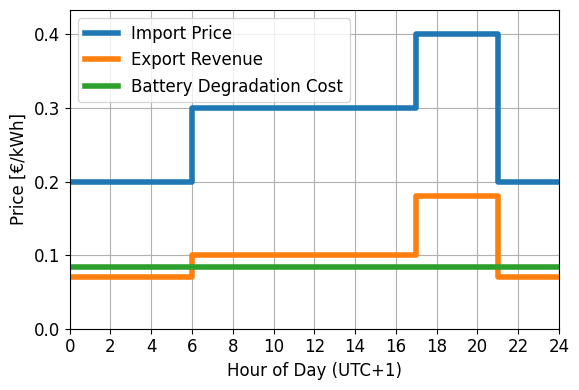

import_price  export_price  c_bat_deg
0            0.2          0.07      0.084
1            0.2          0.07      0.084
2            0.2          0.07      0.084
3            0.2          0.07      0.084
4            0.2          0.07      0.084
5            0.2          0.07      0.084
6            0.3          0.10      0.084
7            0.3          0.10      0.084
8            0.3          0.10      0.084
9            0.3          0.10      0.084
10           0.3          0.10      0.084
11           0.3          0.10      0.084
12           0.3          0.10      0.084
13           0.3          0.10      0.084
14           0.3          0.10      0.084
15           0.3          0.10      0.084
16           0.3          0.10      0.084
17           0.4          0.18      0.084
18           0.4          0.18      0.084
19           0.4          0.18      0.084
20           0.4          0.18      0.084
21           0.2          0.07      0.084
22           0.2          0.07      0.084
23           0.2          0.07      0.084
24           0.2          0.07      0.084

In [6]:
# plot one day of the tou prices
df_tou_day = df_tou.loc["2020-01-01"]
df_tou_day
#df_tou_day.plot(grid=True, title='TOU Prices for 2020-01-01', ylabel='Price (EUR/kWh)', xlabel='Timestamp')

# overwrite the index to only contain the hourly values
df_tou_day.index = df_tou_day.index.hour
# Now only take only one entry per hour (the first one)
df_tou_day = df_tou_day[~df_tou_day.index.duplicated(keep='first')]

# Now plot the prices as step function
import matplotlib.pyplot as plt
# append a final value at hour 24 to close the step function


# shift all values one step ahead since I want to display it not in UTC but in local time (UTC+1)
df_tou_day.index = df_tou_day.index + 1
# wrap around the last value to 0
df_tou_day.index = df_tou_day.index % 24
df_tou_day = df_tou_day.sort_index()

df_tou_day = pd.concat([
    df_tou_day,
    pd.DataFrame({'import_price': df_tou_day['import_price'].iloc[-1],
                  'export_price': df_tou_day['export_price'].iloc[-1],
                  'c_bat_deg': df_tou_day['c_bat_deg'].iloc[-1]},
                 index=[24])
])

plt.figure(figsize=(6, 4))

plt.step(df_tou_day.index, df_tou_day['import_price'], where='post', label='Import Price', linewidth=4)
plt.step(df_tou_day.index, df_tou_day['export_price'], where='post', label='Export Revenue', linewidth=4)
plt.step(df_tou_day.index, df_tou_day['c_bat_deg'], where='post', label='Battery Degradation Cost', linewidth=4)
#plt.title('TOU Prices for 2020-01-01')
plt.xlabel('Hour of Day (UTC)')
plt.ylabel('Price (EUR/kWh)')
plt.xlim(0, 24)
# only show x-ticks for every second hour

fontsize=12

plt.xticks(range(0, 25, 2), fontsize=fontsize)
#plt.xticks(range(0, 25))
#plt.grid(True)
# increase the fontsize of the labels and legend
plt.yticks(fontsize=fontsize)
plt.xlabel('Hour of Day (UTC+1)', fontsize=fontsize)
plt.ylabel('Price [€/kWh]', fontsize=fontsize)

plt.legend(fontsize=fontsize, loc='upper left')
plt.grid()
plt.tight_layout()
plt.ylim(0.0, 0.433)
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4], fontsize=fontsize)
#plt.savefig('tou-prices-small.pdf')
plt.show()
df_tou_day

In [4]:
df_tou.iloc[60:90]

import_price  export_price  c_bat_deg
timestamp                                                       
2020-01-01 15:00:00+00:00           0.3          0.10      0.084
2020-01-01 15:15:00+00:00           0.3          0.10      0.084
2020-01-01 15:30:00+00:00           0.3          0.10      0.084
2020-01-01 15:45:00+00:00           0.3          0.10      0.084
2020-01-01 16:00:00+00:00           0.4          0.18      0.084
2020-01-01 16:15:00+00:00           0.4          0.18      0.084
2020-01-01 16:30:00+00:00           0.4          0.18      0.084
2020-01-01 16:45:00+00:00           0.4          0.18      0.084
2020-01-01 17:00:00+00:00           0.4          0.18      0.084
2020-01-01 17:15:00+00:00           0.4          0.18      0.084
2020-01-01 17:30:00+00:00           0.4          0.18      0.084
2020-01-01 17:45:00+00:00           0.4          0.18      0.084
2020-01-01 18:00:00+00:00           0.4          0.18      0.084
2020-01-01 18:15:00+00:00           0.4          0.18      0.084
2020-01-01 18:30:00+00:00           0.4          0.18      0.084
2020-01-01 18:45:00+00:00           0.4          0.18      0.084
2020-01-01 19:00:00+00:00           0.4          0.18      0.084
2020-01-01 19:15:00+00:00           0.4          0.18      0.084
2020-01-01 19:30:00+00:00           0.4          0.18      0.084
2020-01-01 19:45:00+00:00           0.4          0.18      0.084
2020-01-01 20:00:00+00:00           0.2          0.07      0.084
2020-01-01 20:15:00+00:00           0.2          0.07      0.084
2020-01-01 20:30:00+00:00           0.2          0.07      0.084
2020-01-01 20:45:00+00:00           0.2          0.07      0.084
2020-01-01 21:00:00+00:00           0.2          0.07      0.084
2020-01-01 21:15:00+00:00           0.2          0.07      0.084
2020-01-01 21:30:00+00:00           0.2          0.07      0.084
2020-01-01 21:45:00+00:00           0.2          0.07      0.084
2020-01-01 22:00:00+00:00           0.2          0.07      0.084
2020-01-01 22:15:00+00:00           0.2          0.07      0.084

In [ ]:
#df_tou.to_csv('tou_prices_cdeg8.csv')

In [4]:
import pandas as pd

# create prices for quadratic objective
def quad_prices(imp_quad=0.05, exp_quad=0.015, imp_lin=0.25, exp_lin=0.15):
    # 1) Build a UTC index covering all of 2020 in 15-min steps
    idx_utc = pd.date_range("2020-01-01 00:00:00", "2021-01-01 00:00:00", freq="15min", tz="UTC", inclusive="left")

    # 4) Assemble DataFrame with UTC timestamps
    df = pd.DataFrame({
        "timestamp": idx_utc,
        "import_quad": imp_quad,
        "export_quad": exp_quad,
        "import_lin": imp_lin,
        "export_lin": exp_lin,
    }).set_index("timestamp")
    return df

def exponential_prices(imp_c=0.5, imp_A=0.3571, imp_k=0.7, exp_A=0.1765, exp_k=0.8503):
    # 1) Build a UTC index covering all of 2020 in 15-min steps
    idx_utc = pd.date_range("2020-01-01 00:00:00", "2021-01-01 00:00:00", freq="15min", tz="UTC", inclusive="left")

    # 4) Assemble DataFrame with UTC timestamps
    df = pd.DataFrame({
        "timestamp": idx_utc,
        "import_c": imp_c,
        "import_A": imp_A,
        "import_k": imp_k,
        "export_A": exp_A,
        "export_k": exp_k,
    }).set_index("timestamp")
    return df

In [5]:
# Default values => quad_prices.csv
# df = quad_prices()
# df

# quad_prices2.csv
df = quad_prices(imp_quad=1.0, exp_quad=1.0, imp_lin=0.0, exp_lin=0.0)
df

# Exponential prices => exponential_prices.csv
# df = exponential_prices()
# df

# exponential_prices2.csv
# df = exponential_prices(imp_c=0.4, imp_A=0.1716, imp_k=0.8742, exp_A=0.1716, exp_k=0.8742)
# df

import_quad  export_quad  import_lin  export_lin
timestamp                                                                  
2020-01-01 00:00:00+00:00          1.0          1.0         0.0         0.0
2020-01-01 00:15:00+00:00          1.0          1.0         0.0         0.0
2020-01-01 00:30:00+00:00          1.0          1.0         0.0         0.0
2020-01-01 00:45:00+00:00          1.0          1.0         0.0         0.0
2020-01-01 01:00:00+00:00          1.0          1.0         0.0         0.0
...                                ...          ...         ...         ...
2020-12-31 22:45:00+00:00          1.0          1.0         0.0         0.0
2020-12-31 23:00:00+00:00          1.0          1.0         0.0         0.0
2020-12-31 23:15:00+00:00          1.0          1.0         0.0         0.0
2020-12-31 23:30:00+00:00          1.0          1.0         0.0         0.0
2020-12-31 23:45:00+00:00          1.0          1.0         0.0         0.0

[35136 rows x 4 columns]

In [6]:
df.to_csv('quad_prices2.csv')